In [1]:
import glob
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import Point, Polygon
from pyproj import Proj,Transformer
from rasterio.warp import calculate_default_transform, reproject, Resampling
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
import json
import shapely
import numpy as np
import changeos
from PIL import Image
from rasterio.windows import Window
from rasterio.windows import from_bounds
import datetime
import pandas as pd


def get_norm(src):
    ras=rasterio.open(src)
    data=ras.read(3)
    data=data[data>0]
    mean=np.mean(data)
    stddev=np.std(data)
    print(mean, stddev)

#get_norm('../data/Gaza/skysat/pre_war/20230526_074333_ssc12_u0005_visual.tif')

def convert_coords(y, x, in_crs, out_crs):
    transformer = Transformer.from_crs(in_crs, out_crs)
    x, y = transformer.transform(x, y)

    return Point(x, y)

def move_pt(pt, x, y):
    return Point(pt.x+x, pt.y+y)

def find_tifs(pt, nov_tifs):
    tifs=[]
    for tif in nov_tifs:
        with rasterio.open(tif) as src:
            bbox_polygon = Polygon([(src.bounds.left, src.bounds.bottom),
                                    (src.bounds.right, src.bounds.bottom),
                                    (src.bounds.right, src.bounds.top),
                                    (src.bounds.left, src.bounds.top),
                                    (src.bounds.left, src.bounds.bottom)])
            if bbox_polygon.contains(pt):
                tifs.append(tif)
    return tifs

def reproj(src, target_crs):
    if type(src) == str:
        src = rasterio.open(src)

    source_crs = src.crs
    source_data = src.read()
    out_meta = src.meta.copy()

    transform, width, height = calculate_default_transform(
        source_crs, target_crs, src.width, src.height, *src.bounds
    )
    out_meta.update({'transform': transform, 'width': width, 'height': height, 'crs': target_crs})
    dst = rasterio.MemoryFile().open(**out_meta)

    reproject(
        source=source_data,
        destination=rasterio.band(dst, 1),
        src_transform=src.transform,
        src_crs=source_crs,
        dst_transform=transform,
        dst_crs=target_crs,
        resampling=Resampling.nearest,
    )

    return dst

def hist_match(source, reference):
    """
    Adjust the values of a source array
    so that its histogram matches that of a reference array
    """
    orig_shape = source.shape
    source = source.ravel()
    reference = reference.ravel()

    # get the set of unique pixel values
    # and their corresponding indices and counts
    s_values, s_idx, s_counts = np.unique(
        source, return_inverse=True, return_counts=True)
    r_values, r_counts = np.unique(reference, return_counts=True)

    # take the cumsum of the counts; empirical cumulative distribuition
    s_quantiles = np.cumsum(s_counts).astype(np.float64) / source.size
    r_quantiles = np.cumsum(r_counts).astype(np.float64) / reference.size

    # Create the lookup table,
    # find values in the reference corresponding to the quantiles in the source
    interp_r_values = np.interp(s_quantiles, r_quantiles, r_values)

    # using the inverted source indicies, map to the interpolated pixel values
    # and reshape to the original array
    return interp_r_values[s_idx].reshape(orig_shape)

def buffer_crop(tifs, point, buffer, pwtt=False):
    buffer=box(point.x-buffer, point.y-buffer, point.x+buffer, point.y+buffer)    
    if pwtt:
        src=tifs
    else:
        m, sd= 75.82651559997865, 22.942295287844033
        means=[]
        zscores=[]
        for tif in tifs:
            with rasterio.open(tif, BIGTIFF=True) as src:
                try:
                    data=src.read(3, window=from_bounds(buffer.bounds[0], buffer.bounds[1], buffer.bounds[2], buffer.bounds[3], src.transform))
                    binary_data=np.where(data>0, 1, 0)
                    zscore=(data-m)/sd
                    zscore=np.abs(np.round(np.mean(zscore), 2))
                    mean=np.round(np.mean(binary_data),2)
                    means.append(mean)
                    zscores.append(zscore)
                except:
                    print(f'Error reading {tif}')
                    means.append(0)
                    zscores.append(1000)

        df=pd.DataFrame({'tif':tifs, 'mean':means, 'zscore':zscores})
        df.sort_values(by='zscore', inplace=True)
        df.sort_values(by='mean', ascending=False, inplace=True)
        src=rasterio.open(df.iloc[0]['tif'], window=from_bounds(buffer.bounds[0], buffer.bounds[1], buffer.bounds[2], buffer.bounds[3], src.transform))
    
    gdf = gpd.GeoDataFrame({'geometry': buffer}, index=[0], crs=src.crs)

    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "bounds": buffer.bounds,
    })

    dataset=rasterio.MemoryFile().open(**out_meta)
    dataset.write(out_image)

    return dataset

def get_tifs(post_dir, pt):
    #skysat_dir='../data/Gaza/skysat/'
    skysat_dir='/Volumes/LaCie/gaza_skysat/'
    #folders=os.listdir(skysat_dir)
    post_tifs=[tif for tif in glob.glob(f'{skysat_dir}{post_dir}/*.tif')]
    pre_tifs=[tif for tif in glob.glob(f'{skysat_dir}pre_war/*.tif')]
    pre_tifs=find_tifs(pt, pre_tifs)
    post_tifs=find_tifs(pt, post_tifs)
    return pre_tifs, post_tifs

def generate_centroids(scale):
    admin=gpd.read_file('../data/Gaza/admin_bounds/GazaStrip_MunicipalBoundaries.shp')
    admin=admin.to_crs('epsg:32636')
    unosat=gpd.read_file('../data/Gaza/Gaza_20240503_2_footprints.csv')
    unosat['geometry']=unosat['.geo'].apply(lambda x: shapely.geometry.shape(json.loads(x)))
    unosat=gpd.GeoDataFrame(unosat, geometry='geometry', crs='EPSG:4326')
    unosat=unosat.to_crs('epsg:32636')
    #get bounds of unosat 
    xmin, ymin, xmax, ymax = unosat.total_bounds
    #grid of points 500m apart
    x=np.arange(xmin, xmax, (scale*2)-50)
    y=np.arange(ymin, ymax, (scale*2)-50)
    #x=np.arange(xmin, xmax, (scale*2))
    #y=np.arange(ymin, ymax, (scale*2))
    
    points=[]
    for i in x:
        for j in y:
            points.append(Point(i,j))
    points=gpd.GeoDataFrame(geometry=points, crs='epsg:32636')
    #keep points if they fall within admin 
    points=points[points.within(admin.geometry.union_all())]
    print(len(points))
    return points

def inference(pt,window,folder, unosat):
    model = changeos.from_name('changeos_r101')

    pre_tifs, post_tifs=get_tifs(folder, pt)
    try:
        post=buffer_crop(post_tifs, pt, window)
    except:
        print('Error reading tifs at ', pt)
        return
    
    post_filename=post_tifs[0].split('/')[-1]
    post_filename=post_filename.split('.')[0]

    center=Point(post.bounds[0]+window/2, post.bounds[1]+window/2)
    x,y=int(center.x), int(center.y)
    if window==600:
        pre=rasterio.open(f'../data/Gaza/skysat/pre_war_500/pre_war_{window}_{x}_{y}.tif')
    else:
        pre=buffer_crop(pre_tifs, pt, window)

    outfile=f'../data/Gaza/skysat/{folder}_output/labels/{post_filename}_{window}_{x}_{y}.csv'

    if os.path.exists(outfile):
        pre.close()
        post.close()
        return
    else:
        try:
            xmin, ymin, xmax, ymax = pre.bounds
            unosat=unosat.clip(box(xmin, ymin, xmax, ymax))
            centroids=unosat['geometry'].centroid
            coord_list=[(x.x, x.y) for x in centroids]

            pre_image=pre.read([1,2,3]).transpose(1,2,0)
            post_image=post.read([1,2,3]).transpose(1,2,0)
            pre_image=Image.fromarray(pre_image).resize((1024,1024))
            post_image=Image.fromarray(post_image).resize((1024,1024))

            loc, dam = model(pre_image, post_image)
            #show(post.read([1,2,3]), transform=post.transform)

            post.write(dam, 4)
            
            unosat['damage']=[x[3] for x in post.sample(coord_list)]
            unosat.to_csv(outfile, index=False)
            with rasterio.open(outfile.replace('csv','tif').replace('labels','images'), 'w', **post.meta) as dst:
                dst.write(post.read([1,2,3,4]).astype(rasterio.uint8))
            #with rasterio.open(f'../data/Gaza/skysat/pre_war_500/pre_war_{window}_{x}_{y}.tif', 'w', **pre.meta) as dst:
            #    dst.write(pre.read([1,2,3,4]).astype(rasterio.uint8))
            pre.close()
            post.close()
        except:
            print('Error processing tif ', post_tifs[0])
            return
    return
    
def load_unosat(folder, cols=['geometry', 'class', 'FID', 'area']):
    ym=folder.replace('_','')
    if folder == '2023_12':
        path='../data/Gaza/Gaza_20231126_2_footprints.csv'
    elif folder == '2024_03':
        path='../data/Gaza/Gaza_20240229_2_footprints.csv'
    else:   
        path=glob.glob(f'../data/Gaza/Gaza_{ym}*_2_footprints.csv')[0]
    unosat=gpd.read_file(path)
    unosat['geometry']=unosat['.geo'].apply(lambda x: shapely.geometry.shape(json.loads(x)))
    unosat=gpd.GeoDataFrame(unosat, geometry='geometry', crs='EPSG:4326')
    unosat['date']=datetime.datetime.strptime(path.split('/')[-1].split('_')[1], '%Y%m%d')
    unosat=unosat[cols]
    return unosat

#pt=Point(630023,3476129)
pt=Point(626624.5,3463788.1)
plot_row(pt, 500, '2023_11')


NameError: name 'plot_row' is not defined

In [ ]:
import pandas as pd 
from pandarallel import pandarallel
from joblib import Parallel, delayed
import tqdm 
from tqdm.auto import tqdm

model = changeos.from_name('changeos_r101')

def parallel_inference(scale, folder):
    unosat=load_unosat(folder)
    points=generate_centroids(scale)
    out_folder=f'../data/Gaza/skysat/{folder}_output'
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
        os.makedirs(f'{out_folder}/images')
        os.makedirs(f'{out_folder}/labels')
    
    unosat=unosat.to_crs('epsg:32636')

    Parallel(n_jobs=1)(delayed(inference)(x, scale, folder, unosat) for x in tqdm(points['geometry']))
    #inference(points['geometry'].iloc[150], scale, folder, unosat)

scale=500
#parallel_inference(scale, '2023_11')
#parallel_inference(scale, '2023_12')
#parallel_inference(scale, '2024_01')
#parallel_inference(scale, '2024_03')
parallel_inference(300, '2024_05')






399


  0%|          | 0/399 [00:00<?, ?it/s]

Error processing tif  /Volumes/LaCie/gaza_skysat/2024_01/khan_yunis_20240104_120434_ssc7_u0003_visual_geo.tif
Error processing tif  /Volumes/LaCie/gaza_skysat/2024_01/khan_yunis_20240104_120434_ssc7_u0003_visual_geo.tif
Error processing tif  /Volumes/LaCie/gaza_skysat/2024_01/deir_el_balah_khan_yunis_20240119_071552_ssc12_u0001_visual_clip.tif
Error processing tif  /Volumes/LaCie/gaza_skysat/2024_01/rafah_20240102_065749_ssc4_u0001_visual_clip.tif
1200


  0%|          | 0/1200 [00:00<?, ?it/s]

Error reading /Volumes/LaCie/gaza_skysat/2024_05/rafah_20240526_115523_ssc6_u0001_visual_clip_file_format.tif
Error processing tif  /Volumes/LaCie/gaza_skysat/2024_05/deir_el_balah_20240531_115548_ssc7_u0002_visual_clip_file_format.tif
Error processing tif  /Volumes/LaCie/gaza_skysat/2024_05/deir_el_balah_20240531_115548_ssc7_u0002_visual_clip_file_format.tif
Error processing tif  /Volumes/LaCie/gaza_skysat/2024_05/deir_el_balah_20240531_115548_ssc7_u0002_visual_clip_file_format.tif
Error reading /Volumes/LaCie/gaza_skysat/2024_05/rafah_20240526_115523_ssc6_u0001_visual_clip_file_format.tif
Error processing tif  /Volumes/LaCie/gaza_skysat/2024_05/rafah-crossing-road_20240505_121149_ssc6d2_visual_rgb_50cm_geo.tif
Error reading /Volumes/LaCie/gaza_skysat/2024_05/rafah_20240526_115523_ssc6_u0001_visual_clip_file_format.tif
Error processing tif  /Volumes/LaCie/gaza_skysat/2024_05/rafah-crossing-road_20240505_121149_ssc6d2_visual_rgb_50cm_geo.tif
Error reading /Volumes/LaCie/gaza_skysat/202

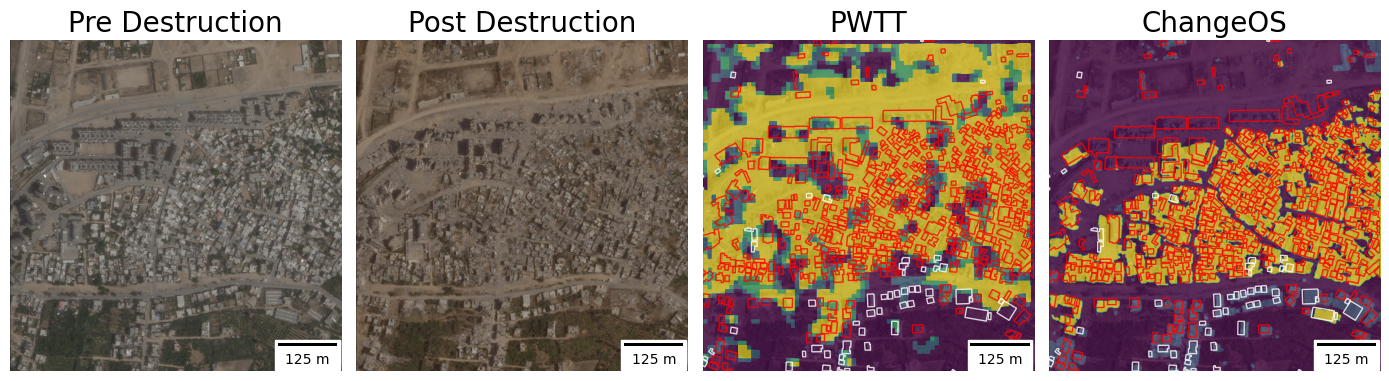

In [55]:
import numpy as np
import changeos
from PIL import Image

def plot_row(pt,window, folder, titles=False):
    model = changeos.from_name('changeos_r101') # take 'changeos_r101' as example
    pre_tifs, post_tifs=get_tifs(folder, pt)
    
    unosat=load_unosat(folder)
    pwtt=rasterio.open('../data/Gaza/Gaza_20240503_2_raster.tif')
    pwtt=reproj(pwtt, 'epsg:32636')
    pwtt=buffer_crop(pwtt, pt, window, pwtt=True)

    fig, ax = plt.subplots(1,4, figsize=(14, 4))

    pre=buffer_crop(pre_tifs, pt, window)
    post=buffer_crop(post_tifs, pt, window)

    xmin, ymin, xmax, ymax = pre.bounds
    unosat=unosat.to_crs(post.crs)
    unosat=unosat.clip(box(xmin, ymin, xmax, ymax))
    damaged=unosat[unosat['class']=='1']
    undamaged=unosat[unosat['class']=='0']

    pre_rgb=hist_match(pre.read([1,2,3]), post.read([1,2,3])).astype(np.uint8)


    pre_image=pre.read([1,2,3]).transpose(1,2,0)
    post_image=post.read([1,2,3]).transpose(1,2,0)
    #rescale the images to 1024x1024 
    pre_image=Image.fromarray(pre_image).resize((1024,1024))
    post_image=Image.fromarray(post_image).resize((1024,1024))

    loc, dam = model(pre_image, post_image)
    #loc, dam = changeos.visualize(loc, dam)
    
    post.write(dam, 4)
    pre.write(pwtt.read(1), 4)
    # # plot the prediction
    #unosat.plot(ax=ax[2], color='red', alpha=0.6,markersize=10)
    

    lw=1
    show(pre.read([1,2,3]),transform=pre.transform, ax=ax[0])

    show(post.read([1,2,3]),transform=post.transform, ax=ax[1])

    show(post.read([1,2,3]),transform=post.transform, ax=ax[2])
    show(pre.read(4),transform=post.transform, ax=ax[2],vmin=3, vmax=6, alpha=0.6)
    damaged.plot(ax=ax[2], edgecolor='red', alpha=0.8, lw=lw, facecolor='none')
    undamaged.plot(ax=ax[2], edgecolor='white', alpha=0.8, lw=lw, facecolor='none')

    show(post.read([1,2,3]),transform=post.transform, ax=ax[3])
    show(post.read(4),transform=post.transform, ax=ax[3],vmin=0, vmax=4, alpha=0.6)
    damaged.plot(ax=ax[3], edgecolor='red', alpha=0.8, lw=lw, facecolor='none')
    undamaged.plot(ax=ax[3], edgecolor='white', alpha=0.8, lw=lw, facecolor='none')
    titles=['Pre Destruction', 'Post Destruction', 'PWTT', 'ChangeOS']
    i=0
    for a in ax:
        scalebar = ScaleBar(1, units='m', location='lower right')

        a.set_xlim(xmin, xmax)
        a.set_ylim(ymin, ymax)
        a.axis('off')
        # remove axis ticklabels 
        #a.set_xticklabels([])
        #a.set_yticklabels([])
        if titles:
            a.set_title(titles.pop(0), fontsize=20)
        a.add_artist(scalebar)

    plt.tight_layout()
    plt.savefig('../figs/pwtt_changeos_comparison.png', dpi=300)
    plt.show()


beit_hanoun=convert_coords(34.522359,31.546570, 'epsg:4326','epsg:32636')
central_gaza=convert_coords(34.40163,31.43744, 'epsg:4326','epsg:32636')
nw_gaza=Point(633289.384,3482754.016)
low_density=Point(633359.34,3481677.71)

pt=beit_hanoun
#window=256
window=100
pt=move_pt(pt, 0, 50)
#350 seems best
windows=range(100, 300, 20)
#for window in windows:
#     print(window)
     #plot_row(beit_hanoun, window, '2023_11')

plot_row(pt, 350, '2024_04')
#plot_row(nw_gaza, 300, '2024_05', titles=False)
#plot_row(central_gaza, 500, '2024_05', titles=False)


In [ ]:
pt=points.iloc[1400].geometry
#plot_row(pt, 400)
windows=range(300, 500, 20)
for window in windows:
     print(window)
     plot_row(pt, window)


NameError: name 'points' is not defined

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd 
import glob
import geopandas as gpd
import shapely
import json
from sklearn.metrics import f1_score, precision_score, recall_score


folders=os.listdir('../data/Gaza/skysat/')
folders=[x for x in folders if 'output' in x]
scale='500'

results=pd.DataFrame()
for folder in folders:
    folder=folder.replace('_output','') 
    unosat=load_unosat(folder, cols=['geometry', 'class', 'FID', 'area','max_change','k50','k100','date'])
    #get unosat filename
    print(folder)
    fp=pd.DataFrame()
    for file in glob.glob(f'../data/Gaza/skysat/{folder}_output/labels/*.csv'):
        filename=file.split('/')[-1]
        file_scale=filename.split('_')[-3]
        if file_scale==scale:
            try:
                df=pd.read_csv(file)
                fp=pd.concat([fp, df])
            except:
                print('Error reading ', file)

    fp['FID']=fp['FID'].astype(int)
    unosat['FID']=unosat['FID'].astype(int)
    fp = fp.drop_duplicates(subset='FID')
    merged=unosat.merge(fp[['FID','damage']], on='FID', how='left')
    merged['pred']=np.where(merged['damage']>0, 1, 0)
    merged['class']=merged['class'].astype(int)
    merged['area']=merged['area'].astype(float)
    print('Missing: ', merged['damage'].isna().sum())
    
    #merged=merged.dropna(subset='damage')
    merged=merged.fillna(0)
    merged=merged[merged['area']>50]

    merged['max_change']=merged['max_change'].astype(float)
    merged['change']=merged[['max_change','k50','k100']].astype('float').mean(axis=1)
    
    area=merged['area']

    cos_f1 = f1_score(merged['class'], merged['pred'], sample_weight=area, average='binary')
    cos_precision = precision_score(merged['class'], merged['pred'], sample_weight=area, average='binary')
    cos_recall = recall_score(merged['class'], merged['pred'], sample_weight=area, average='binary')
    cos_auc=roc_auc_score(merged['class'], merged['max_change'], sample_weight=area)

    precision, recall, thresholds = precision_recall_curve(merged['class'], merged['max_change'], sample_weight=area)
    f1=(2 * (precision * recall) / (precision + recall))
    f1=f1[~np.isnan(f1)]
    ix = np.argmax(f1)
    threshold = thresholds[ix]        
    print('Threshold: ', threshold) 
    threshold=3.5
    y_pred = np.where(merged['change'] > threshold, 1, 0)

    pr_f1 = f1_score(merged['class'], y_pred, sample_weight=area, average='binary')
    pr_precision = precision_score(merged['class'], y_pred, sample_weight=area, average='binary')
    pr_recall = recall_score(merged['class'], y_pred, sample_weight=area, average='binary')
    pr_auc=roc_auc_score(merged['class'], merged['change'], sample_weight=area)
    date=unosat['date'].iloc[0].strftime('%Y-%m-%d')
    multicolumn=pd.MultiIndex.from_product([['ChangeOS', 'PWTT'], ['F1', 'Precision', 'Recall', 'AUC']])
    row=pd.DataFrame([[cos_f1, cos_precision, cos_recall, cos_auc, pr_f1, pr_precision, pr_recall, pr_auc]], columns=multicolumn, index=[date]).reset_index(names='Date')
    results=pd.concat([results, row])

results=results.sort_values('Date')

mean=results.drop('Date', axis=1).mean()
mean['Date']='Average'
results=pd.concat([results, mean.to_frame().T])
results['ChangeOS']=results['ChangeOS']*100
results['PWTT']=results['PWTT']*100

latex=results.to_latex(index=False, float_format="%.2f")
print(latex)    
results

2023_11
Missing:  2699


/var/folders/v8/1pmfp2n52yg0xbnknpm7_7xh0000gn/T/ipykernel_1515/28468996.py:57: RuntimeWarning: invalid value encountered in divide
  f1=(2 * (precision * recall) / (precision + recall))


Threshold:  3.7117568048713303
2024_05
Error reading  ../data/Gaza/skysat/2024_05_output/labels/khan_yunis_20240519_031845_ssc14_u0003_visual_clip_file_format_500_617698_3466273.csv
Missing:  2662
Threshold:  2.7804631676178224
2024_01
Missing:  4316
Threshold:  3.0946300316308473
2024_03
Missing:  2480
Threshold:  2.740333120086885
2024_04
Missing:  4369


/var/folders/v8/1pmfp2n52yg0xbnknpm7_7xh0000gn/T/ipykernel_1515/28468996.py:57: RuntimeWarning: invalid value encountered in divide
  f1=(2 * (precision * recall) / (precision + recall))


Threshold:  2.7760187338205227
2023_12
Missing:  2480


/var/folders/v8/1pmfp2n52yg0xbnknpm7_7xh0000gn/T/ipykernel_1515/28468996.py:57: RuntimeWarning: invalid value encountered in divide
  f1=(2 * (precision * recall) / (precision + recall))
/var/folders/v8/1pmfp2n52yg0xbnknpm7_7xh0000gn/T/ipykernel_1515/28468996.py:76: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mean=results.drop('Date', axis=1).mean()


Threshold:  3.4722828429169668
\begin{tabular}{lllllllll}
\toprule
Date & \multicolumn{4}{r}{ChangeOS} & \multicolumn{4}{r}{PWTT} \\
 & F1 & Precision & Recall & AUC & F1 & Precision & Recall & AUC \\
\midrule
2023-11-07 & 22.52 & 13.17 & 77.70 & 77.73 & 46.67 & 37.40 & 62.03 & 83.34 \\
2023-11-26 & 32.30 & 20.26 & 79.63 & 77.14 & 54.55 & 45.30 & 68.54 & 83.70 \\
2024-01-07 & 50.33 & 36.58 & 80.66 & 75.11 & 64.25 & 53.10 & 81.33 & 81.33 \\
2024-02-29 & 63.99 & 53.27 & 80.13 & 77.86 & 75.42 & 75.24 & 75.59 & 84.18 \\
2024-04-01 & 63.56 & 53.08 & 79.19 & 77.53 & 75.91 & 74.26 & 77.64 & 84.24 \\
2024-05-03 & 67.09 & 57.93 & 79.71 & 75.92 & 77.75 & 73.82 & 82.13 & 82.69 \\
Average & 49.97 & 39.05 & 79.50 & 76.88 & 65.76 & 59.86 & 74.54 & 83.25 \\
\bottomrule
\end{tabular}



Date   ChangeOS                                        PWTT  \
                      F1  Precision     Recall        AUC         F1   
0  2023-11-07  22.519974  13.168351  77.697681  77.733164  46.665171   
0  2023-11-26   32.30353  20.261743  79.626434   77.14326  54.548793   
0  2024-01-07  50.333381  36.579408  80.662877  75.112929   64.25338   
0  2024-02-29  63.992757  53.266205    80.1288  77.861788  75.415204   
0  2024-04-01  63.561025  53.083343  79.192099  77.528891  75.914976   
0  2024-05-03  67.093821  57.926837  79.707642  75.919302  77.752956   
0     Average  49.967415  39.047648  79.502589  76.883222  65.758413   

                                    
   Precision     Recall        AUC  
0  37.401794  62.027694  83.337767  
0  45.299793  68.543543  83.696357  
0  53.103276  81.330321  81.333437  
0  75.242798  75.588403  84.179785  
0  74.263227  77.641872  84.242255  
0  73.822511  82.125464  82.694837  
0  59.855566  74.542883  83.247406

In [ ]:
results

""


<Axes: >

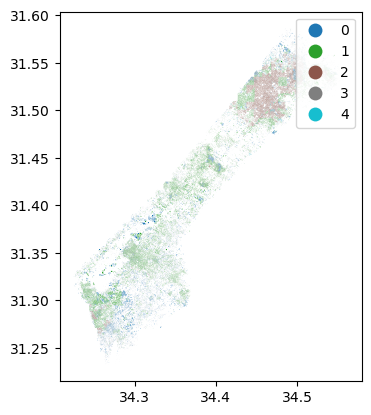

In [ ]:
merged.plot(column='damage', legend=True)